In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import pandas as pd

from sklearn import decomposition, preprocessing
from skimage.feature import greycomatrix, greycoprops
from skimage import exposure

## Feature engineering

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The code and ideas to engineer new features used in this notebook, </span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Matteo Niccoli and Mark Dahl, with contributions by Daniel Kittridge,</span> are licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. 

### 1 - Clean up and rescale data

In [3]:
# import data and filling missing PE values with average

filename = 'nofacies_data.csv'
training_data = pd.read_csv(filename)

training_data['PE'].fillna((training_data['PE'].mean()), inplace=True)
print  np.shape(training_data)
training_data['PE'].fillna((training_data['PE'].mean()), inplace=True)
print  np.shape(training_data)

(830, 10)
(830, 10)


In [5]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
training_data.describe()

,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000
mean,2987.0705,57.6117,0.6663,2.8520,11.6553,3.6542,1.6783,0.5358
std,94.3919,27.5277,0.2884,3.4421,5.1902,0.6498,0.4674,0.2831
min,2808.0000,12.0360,-0.4680,-8.9000,1.8550,2.1130,1.0000,0.0130
25%,2911.6250,36.7733,0.5410,0.4113,7.7000,3.1715,1.0000,0.3000
50%,2993.7500,58.3445,0.6750,2.3975,10.9500,3.5155,2.0000,0.5475
75%,3055.3750,73.0515,0.8508,4.6000,14.7938,4.1915,2.0000,0.7780
max,3160.5000,220.4130,1.5070,16.5000,31.3350,6.3210,2.0000,1.0000


To keep feature importance on a level playing field, we will rescale each WL log before calculating moments. We will use [sklearn.preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [6]:
# standardize features to go into moments calculation
feature_vectors = training_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)
scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [7]:
scaled_vectors_df = pd.DataFrame(scaled_features, columns=list(feature_vectors))
scaled_feat_df = pd.concat((training_data[['Depth', 'Well Name', 'Formation']], scaled_vectors_df),1)
scaled_feat_df.head()

,Depth,Well Name,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,2808.0000,STUART,A1 SH,0.3149,-0.1260,0.1302,-0.1938,-0.0973,-1.4521,1.6409
1,2808.5000,STUART,A1 SH,0.7139,-0.2821,1.0605,0.0568,-0.4823,-1.4521,1.5631
2,2809.0000,STUART,A1 SH,0.9192,-0.3481,1.9035,0.3749,-0.9088,-1.4521,1.4854
3,2809.5000,STUART,A1 SH,0.8382,-0.2544,1.9326,0.3074,-1.0428,-1.4521,1.4040
4,2810.0000,STUART,A1 SH,0.6673,-0.0982,1.7000,0.1339,-0.9766,-1.4521,1.3263


In [8]:
scaled_feat_df.shape

(830, 10)

### 2 - Calculate derivatives

The rate of change of a function of series of values is commonly used as a booster for machine learning classifiers. We will calculate the first and second derivatives for each WL log curve in each well.

In [9]:
# calculate all 1st and 2nd derivative for all logs, for all wells

derivative_df = pd.DataFrame()             # final dataframe

grouped = training_data['Well Name'].unique()

for well in grouped:                  # for each well     
    new_df = pd.DataFrame()           # make a new temporary dataframe 
   
    for log in ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND' ,'PE']:
        d1 = np.array(np.gradient(scaled_feat_df[log][scaled_feat_df['Well Name'] == well]))
        d2 = np.array(np.gradient(np.gradient(scaled_feat_df[log][scaled_feat_df['Well Name'] == well])))
                                      # write to temporary dataframe 
        new_df[str(log) + '_d1'] = d1
        new_df[str(log) + '_d2'] = d2
                                      # append all rows of temporary dataframe to final dataframe          

    derivative_df = pd.concat([derivative_df, new_df])

In [10]:
derivative_df.describe()

,GR_d1,GR_d2,ILD_log10_d1,ILD_log10_d2,DeltaPHI_d1,DeltaPHI_d2,PHIND_d1,PHIND_d2,PE_d1,PE_d2
count,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000
mean,0.0017,0.0002,0.0003,0.0002,0.0017,-0.0010,0.0027,0.0007,-0.0002,-0.0008
std,0.2650,0.1317,0.1938,0.1014,0.2992,0.2012,0.3473,0.2163,0.2865,0.1593
min,-1.4377,-0.8662,-1.2145,-0.6853,-1.2936,-0.7485,-1.4025,-1.3435,-1.0232,-0.7334
25%,-0.1033,-0.0515,-0.0880,-0.0373,-0.1434,-0.0944,-0.1539,-0.0733,-0.1446,-0.0619
50%,0.0109,0.0044,-0.0139,0.0026,0.0029,0.0073,0.0017,0.0048,-0.0162,0.0006
75%,0.1061,0.0618,0.0850,0.0425,0.1599,0.0945,0.1398,0.0936,0.0986,0.0668
max,1.4765,0.4139,1.0826,0.6350,1.6570,1.1337,2.0194,0.8892,1.6130,0.7869


### 3 - Create a list of geometrically-expanding windows for rolling features

Facies are interpreted groupings of rocks and commonly composed of a several rock elements, each demonstrating different properties. Therefore, we should expect to see a distribution of WL log responses for each facies. A corollary of this is that attempting to directly solve for a facies with WL log responses at any given depth will be tenuous. Facies require a context; a context provided by the surrounding rock. Likewise, if we are to effectively solve for facies from WL logs, we should provide a context to for each response at a given depth. We can accomplish this with *rolling windows*.

A rolling window provides a local neighbourhood of values about a central point, which can be stepped through an array of values. The neighbourhood sample size, which is the depth thickness/sampling rate, of the neighbourhood evaluated should relate directly to the thickness of a facies. Because facies are observed with different thicknesses, we will build neighbourhoods to include the thickest observed facies. To keep the number of rolling windows reasonable, we will use a geometric function where the half window length is doubled for each subsequent value.

In [11]:
# import file
filename = 'facies_vectors.csv'
data = pd.read_csv(filename)

# eliminate nulls
PE_mask = data['PE'].notnull().values
data = data[PE_mask]

# get facies
y = data['Facies'].values

# get longest facies 
max_len = max(len(list(s)) for (c,s) in itertools.groupby(y))
max_len

68

In [12]:
# function to create a geometric series of window sizes 
# using powers of 2 up to one just above a reference geological size (longest facies)

def geom_windows(max_sz): 
    """returns a list of square window sizes using powers of two"""
    return list(int(2**(n+1)+1) for n in np.arange(np.ceil(np.log2(max_sz))))

In [13]:
# window sizes
sizes = geom_windows(max_len)
sizes

[3, 5, 9, 17, 33, 65, 129]

### 4 - Moments feature generation

The simplest and most fundamental way to numerically describe the shape of a distribution of values is using [moments](http://www.statisticshowto.com/what-is-a-moment/). The first moment, [mean](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html#numpy.mean) $\mu$, characterizes the central tendency of the distribution. The second moment, [variance](https://docs.scipy.org/doc/numpy/reference/generated/numpy.var.html#numpy.var) $\sigma^2$, characterizes the spread of the values about the central tendency. The third moment, [skewness](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html) $\gamma_1$, characterizes the symmetry (or lack thereof) about the central tendency.

We will calculate the first three moments (with one small modification) for each rolling window size at every depth. The small modification is that instead of variance $\sigma^2$, we are calculating standard deviation $\sigma$ because the results of variance $\sigma^2$ produce values with units of the mean squared $\mu^2$. As a result, feature importance of variance is artificially high due to the dimension of the variance values. Standard deviation $\sigma$ has the same dimension as mean $\mu$.

With respect to facies prediction, now, in addition to the raw WL log inputs, we will describe at multiple scales the shapes of the distributions of WL log responses associated with each facies.

In [14]:
# Efficient rolling statistics with NumPy
# http://www.rigtorp.se/2011/01/01/rolling-statistics-numpy.html

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [15]:
# function to calculate moments using a rolling window

def rollin_moments(arr, w, moment ='mean'):
    """- pad input array by (w-1)/2 samples at the top and bottom
       - apply rolling window function
       - calculate moment: mean (default), var, or skew"""
    mom = []
    arr = np.pad(arr, ((w-1)/2, (w-1)/2), 'edge')  
    if moment == 'std':
        return np.array(np.std(rolling_window(arr, w), 1))
    elif moment == 'skew':
        return np.array(sp.stats.skew(rolling_window(arr, w), 1))
    else:
        return np.array(np.mean(rolling_window(arr, w), 1))

In [16]:
moments = ['mean', 'std', 'skew']

In [17]:
# calculate all moments for all logs, for all wells

moments_df = pd.DataFrame()             # final dataframe

grouped = training_data['Well Name'].unique()

for well in grouped:                  # for each well     
    new_df = pd.DataFrame()           # make a new temporary dataframe 
   
    for log in ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND' ,'PE']:
        for mo in moments:            # for each moment
                                      # calculate the rolling moments with each window size
                                      # and also the mean of moments (all window sizes)
            results = np.array([rollin_moments(scaled_feat_df[log][scaled_feat_df['Well Name'] == well],
                                               size, moment = mo) for size in sizes])
            mean_result = np.mean(results, axis=0)
                                      # write to temporary dataframe 
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[0])] = results[0]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[1])] = results[1]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[2])] = results[2]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[3])] = results[3]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[4])] = results[4]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[5])] = results[5]
            new_df[str(log)+ '_' + str(mo)+'_wsize=' +str(sizes[6])] = results[6]
            new_df[str(log)+ '_' + str(mo)+'_wsize=ave'] = mean_result
                                      # append all rows of temporary dataframe to final dataframe          

    moments_df = pd.concat([moments_df, new_df])

In [18]:
moments_df.describe()

,GR_mean_wsize=3,GR_mean_wsize=5,GR_mean_wsize=9,GR_mean_wsize=17,GR_mean_wsize=33,GR_mean_wsize=65,GR_mean_wsize=129,GR_mean_wsize=ave,GR_std_wsize=3,GR_std_wsize=5,...,PE_std_wsize=129,PE_std_wsize=ave,PE_skew_wsize=3,PE_skew_wsize=5,PE_skew_wsize=9,PE_skew_wsize=17,PE_skew_wsize=33,PE_skew_wsize=65,PE_skew_wsize=129,PE_skew_wsize=ave
count,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,...,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000
mean,-0.0000,0.0000,0.0002,0.0011,0.0035,0.0030,-0.0059,0.0003,0.1472,0.2448,...,0.9189,0.5909,0.0295,0.0082,0.0266,0.1636,0.3223,0.4480,0.5806,0.2255
std,0.9762,0.9367,0.8469,0.6990,0.5061,0.3450,0.2315,0.5721,0.1629,0.2519,...,0.2495,0.2278,0.4426,0.6299,0.7252,0.7299,0.6050,0.4907,0.4267,0.3280
min,-1.6140,-1.5656,-1.4971,-1.3982,-1.0994,-0.7095,-0.4113,-0.9915,0.0000,0.0000,...,0.2094,0.0988,-0.7071,-1.4773,-2.0822,-2.9050,-2.3414,-0.6499,-0.1110,-0.6534
25%,-0.7520,-0.7202,-0.6895,-0.5207,-0.3507,-0.2425,-0.1710,-0.4676,0.0403,0.0770,...,0.7755,0.4476,-0.3291,-0.4495,-0.4587,-0.2996,-0.0458,0.0832,0.2540,-0.0034
50%,0.0208,0.0351,0.0256,-0.0136,-0.0265,-0.0678,-0.0507,0.0162,0.0904,0.1681,...,0.9294,0.5888,0.0129,0.0306,0.0438,0.1474,0.3486,0.4510,0.5065,0.2425
75%,0.5432,0.5256,0.5107,0.4601,0.3487,0.2043,0.0823,0.3489,0.2036,0.3330,...,1.1342,0.7310,0.4276,0.4953,0.4989,0.6038,0.7172,0.8012,0.7933,0.4679
max,5.5963,5.0319,3.7101,2.0829,1.2403,1.2112,0.9123,2.5144,1.2060,1.8474,...,1.2681,1.4662,0.7071,1.4605,2.0767,2.4283,2.6513,1.6184,1.9187,1.2194


### 5 - GLCM feature generation

Statistical moments can be said to characterize the composition of a neighbourhood of values. However, we can easily describe two neighbourhoods with identical composition that are distinctly different. For example *N1* = [00001111] and *N2* = [01010101] have exactly the same mean $\mu$, variance $\sigma^2$, and skewness $\gamma_1$, but, in terms of rocks, might represent different facies. Therefore, in addition to describing the shape of a distribution of values for a facies, we need something to evaluate the ordering of those values. That something is a grey-level coocurrence matrix (GLCM). 

A GLCM is a second order statistical method that numerically describes ordering of elements by evaluating the probability of values to be neighbours. Think of the GLCM as a histogram that preserves the ordering of values. For more about the GLCM, see Mryka Hall-Beyer's [tutorial](http://www.fp.ucalgary.ca/mhallbey/tutorial.htm) and read [skimage.feature.greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix) documentation. Just as we calculated moments to describe the shape of a histogram, we need to represent the arrangement of values in a GLCM with a single value. Properties that capture different characteristics of a GLCM including contrast, dissimilarity, homogeneity, ASM, energy, and correlation can be calculated with [skimage.feature.greycoprops](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops). To keep resulting dimensions equivalent to the moments previously calculated, we will use the properties dissimilarity, energy, and correlation.

In [19]:
# function to calculate glcm and greycoprops using a rolling window

def gprops_calc(arr, w, lv, sym = True, prop='dissimilarity'):
    """- make w copies of the input array, roll it up one row at a time
       - calculate glcm on a square window of size w
       - calculate greycoprops from glcm: dissimilarity (default), energy, or correlation
       - repeat until back at row one
       N.B. the input array is padded by (w-1)/2 samples at the top and bottom"""
    diss = []
    itr = len(arr)
    arr = np.pad(arr, ((w-1)/2, (w-1)/2), 'edge')
    s = np.array([arr,]*w,dtype=np.uint8).transpose()
    for _ in np.arange(itr):
        if sym == True:
            glcm = greycomatrix(s[:w,:], [1], [np.pi/2], levels = lv, symmetric = True, normed = True)
        else:
            glcm = greycomatrix(s[:w,:], [1], [np.pi/2], levels = lv, symmetric = False, normed = True)
        if prop == 'correlation':
            ds = greycoprops(glcm, 'correlation')
        elif prop == 'energy':
            ds = greycoprops(glcm, 'energy')
        else:
            ds = greycoprops(glcm, 'dissimilarity')
        diss.append(ds)
        s = np.roll(s[:, :], -w)
    return np.ndarray.flatten(np.array(diss)) 

In [20]:
methods = ['dissimilarity','energy', 'correlation']

Similar to the step preceeding moments calculation, we will rescale the raw WL logs for GLCM property calculation so each resulting property is unaffected by the magnitude of the raw WL log values. [skimage.feature.greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix) requires uint8 values, so we need an alternative to [sklearn.preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Unlike with calculating moments, preserving the shape of the histogram is not important to the integrity of a GLCM property. We will use [histogram equalization](http://scikit-image.org/docs/dev/auto_examples/plot_equalize.html), which flattens a histogram (puts an equal number of values in each bin). To maximize the effectiveness of a GLCM, it is commonly wise to reduce the bit depth from 8 to avoid processing expense and noise caused by empty matrix entries. After some trial and error, we found the 64 bins works nicely. Note that 64 bins results in a *64x64* matrix at every depth for every rolling window size.

In [23]:
# functions to equalize histogram of features to go into GLCM calculation
def eqlz(arr, bins):
    return (bins-1) * exposure.equalize_hist(arr)
def eqlz_along_axis(arr, bins):
    return np.apply_along_axis(eqlz, 0, arr, bins)

In [24]:
# equalize features
feature_vectors_glcm = training_data.drop(['Formation', 'Well Name', 'Depth'], axis=1)
eq_vectors_glcm = eqlz_along_axis(feature_vectors_glcm, 64)

In [25]:
eq_vectors_glcm_df = pd.DataFrame(eq_vectors_glcm, columns=list(feature_vectors_glcm))
eq_vectors_glcm_df = np.round(eq_vectors_glcm_df).astype(int)
eq_glcm_df = pd.concat((training_data[['Depth', 'Well Name', 'Formation']], eq_vectors_glcm_df),1)
eq_glcm_df.head()

,Depth,Well Name,Formation,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,2808.0000,STUART,A1 SH,40,26,39,30,34,20,63
1,2808.5000,STUART,A1 SH,52,20,56,37,23,20,61
2,2809.0000,STUART,A1 SH,56,18,60,44,11,20,59
3,2809.5000,STUART,A1 SH,55,21,60,42,8,20,58
4,2810.0000,STUART,A1 SH,51,27,59,39,10,20,56


One last consideration for the GLCM is its symmetry. Symmetry in a GLCM refers to a bi-directional evaluation of the reference-neighbour pair. In plain English, if you were to construct a GLCM by hand, you would move through an array in one direction and then in the opposite direction. It is often desirable to do this because this removes the asymmety caused at the edge of a neighbourhood. See Mryka Hall-Beyer's [tutorial](http://www.fp.ucalgary.ca/mhallbey/tutorial.htm) for a full explanation of this. However, since sedimentary rocks (provided that they are structurally undisturbed) are laid down from bottom to top, we thought in addition to the symmetric GLCM, it would be useful to evaluate the asymmetric GLCM where we look at the neighbour above.

First let's calculate symmetric GLCM properties:

In [26]:
glcm_sym_df = pd.DataFrame()        # final dataframe
grouped = training_data['Well Name'].unique()

for well in grouped:                   # for each well   
    new_dfg = pd.DataFrame()           # make a new temporary dataframe 

    for log in ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']:   # for each log
        for me in methods:            # for each property
                                      # calculate rolling GLCM properties with each window size
                                      # and also the mean of moments (all window sizes)
            lg = eq_glcm_df[log][eq_glcm_df['Well Name'] == well]
            results = np.array([gprops_calc(lg.astype(int), wd, lv = 64, sym = True, prop = me) for wd in sizes])
            mean_result = np.mean(results, axis=0)
                                      # write to temporary dataframe 
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[0])] = results[0]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[1])] = results[1]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[2])] = results[2]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[3])] = results[3]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[4])] = results[4]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[5])] = results[5]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=' +str(sizes[6])] = results[6]
            new_dfg[str(log)+ '_GLCM_' + str(me)+'_wsize=ave'] = mean_result
                                      # append all rows of temporary dataframe to final dataframe 

    glcm_sym_df  = pd.concat([glcm_sym_df , new_dfg])

In [29]:
glcm_sym_df.describe()

,GR_GLCM_dissimilarity_wsize=3,GR_GLCM_dissimilarity_wsize=5,GR_GLCM_dissimilarity_wsize=9,GR_GLCM_dissimilarity_wsize=17,GR_GLCM_dissimilarity_wsize=33,GR_GLCM_dissimilarity_wsize=65,GR_GLCM_dissimilarity_wsize=129,GR_GLCM_dissimilarity_wsize=ave,GR_GLCM_energy_wsize=3,GR_GLCM_energy_wsize=5,...,PE_GLCM_energy_wsize=129,PE_GLCM_energy_wsize=ave,PE_GLCM_correlation_wsize=3,PE_GLCM_correlation_wsize=5,PE_GLCM_correlation_wsize=9,PE_GLCM_correlation_wsize=17,PE_GLCM_correlation_wsize=33,PE_GLCM_correlation_wsize=65,PE_GLCM_correlation_wsize=129,PE_GLCM_correlation_wsize=ave
count,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,...,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000
mean,3.4024,3.3952,3.3870,3.3779,3.3520,3.2929,3.1588,3.3380,0.5570,0.4119,...,0.1442,0.2785,-0.2047,0.3351,0.6797,0.8495,0.9198,0.9385,0.9450,0.6375
std,3.1384,2.5533,1.9162,1.4214,1.0729,0.8625,0.7652,1.3525,0.1123,0.0944,...,0.1128,0.0586,0.3917,0.3550,0.2398,0.1252,0.0442,0.0233,0.0167,0.1150
min,0.0000,0.0000,0.0000,0.0625,0.5000,0.9219,0.9219,0.3438,0.5000,0.3536,...,0.0765,0.2264,-1.0000,-0.9109,-0.4545,-0.1193,0.6799,0.8632,0.9016,0.1932
25%,1.0000,1.2500,1.7500,2.3125,2.5938,2.6719,2.7500,2.2243,0.5000,0.3536,...,0.0850,0.2394,-0.3333,0.0993,0.5898,0.8142,0.8934,0.9225,0.9317,0.5754
50%,2.5000,2.7500,3.2500,3.5000,3.3750,3.3594,3.3281,3.2338,0.5000,0.3953,...,0.0880,0.2556,-0.1111,0.4667,0.7535,0.8830,0.9321,0.9441,0.9450,0.6678
75%,5.0000,5.0000,4.8750,4.3750,4.2812,3.9492,3.7500,4.2547,0.6124,0.4330,...,0.1316,0.2937,-0.0196,0.6146,0.8522,0.9271,0.9535,0.9570,0.9606,0.7257
max,15.5000,12.5000,8.3750,6.9375,5.4375,5.1094,4.3516,7.0357,1.0000,1.0000,...,0.5056,0.5397,1.0000,1.0000,0.9193,0.9699,0.9823,0.9770,0.9753,0.8931


And now let's calculate asymmetric GLCM properties using only the upward neighbour:

In [28]:
glcm_asym_df = pd.DataFrame()        # final dataframe
grouped1 = training_data['Well Name'].unique()

for well1 in grouped1:                   # for each well   
    new_dfg1 = pd.DataFrame()           # make a new temporary dataframe 

    for log1 in ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE']:   # for each log
        for me in methods:            # for each property
                                      # calculate rolling GLCM properties with each window size
                                      # and also the mean of moments (all window sizes)
            lg1 = eq_glcm_df[log][eq_glcm_df['Well Name'] == well1]
            results1 = np.array([gprops_calc(lg1.astype(int), wd, lv = 64, sym = False, prop = me) for wd in sizes])
            mean_result1 = np.mean(results1, axis=0)
            
                                      # write to temporary dataframe 
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[0])] = results1[0]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[1])] = results1[1]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[2])] = results1[2]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[3])] = results1[3]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[4])] = results1[4]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[5])] = results1[5]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=' +str(sizes[6])] = results1[6]
            new_dfg1[str(log1)+ '_GLCM_' + str(me)+'_asym_wsize=ave'] = mean_result1
                                      # append all rows of temporary dataframe to final dataframe 

    glcm_asym_df  = pd.concat([glcm_asym_df , new_dfg1])

In [30]:
glcm_asym_df.describe()

,GR_GLCM_dissimilarity_asym_wsize=3,GR_GLCM_dissimilarity_asym_wsize=5,GR_GLCM_dissimilarity_asym_wsize=9,GR_GLCM_dissimilarity_asym_wsize=17,GR_GLCM_dissimilarity_asym_wsize=33,GR_GLCM_dissimilarity_asym_wsize=65,GR_GLCM_dissimilarity_asym_wsize=129,GR_GLCM_dissimilarity_asym_wsize=ave,GR_GLCM_energy_asym_wsize=3,GR_GLCM_energy_asym_wsize=5,...,PE_GLCM_energy_asym_wsize=129,PE_GLCM_energy_asym_wsize=ave,PE_GLCM_correlation_asym_wsize=3,PE_GLCM_correlation_asym_wsize=5,PE_GLCM_correlation_asym_wsize=9,PE_GLCM_correlation_asym_wsize=17,PE_GLCM_correlation_asym_wsize=33,PE_GLCM_correlation_asym_wsize=65,PE_GLCM_correlation_asym_wsize=129,PE_GLCM_correlation_asym_wsize=ave
count,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,...,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000
mean,3.8410,3.8304,3.8161,3.8013,3.7688,3.7163,3.5909,3.7664,0.7195,0.5189,...,0.1568,0.3445,0.6434,0.6096,0.7566,0.8678,0.9222,0.9389,0.9451,0.8119
std,3.8440,3.0058,2.2810,1.6697,1.2653,1.1018,1.0510,1.6288,0.0589,0.0627,...,0.1078,0.0439,0.7660,0.4638,0.2530,0.1222,0.0435,0.0233,0.0167,0.1804
min,0.0000,0.0000,0.2500,0.6250,0.6250,0.5469,0.8281,0.5893,0.7071,0.5000,...,0.0957,0.3158,-1.0000,-0.9683,-0.4523,-0.1193,0.6801,0.8633,0.9019,0.1572
25%,1.5000,1.5000,1.8750,2.5156,3.0938,3.0938,2.8594,2.5991,0.7071,0.5000,...,0.1007,0.3199,1.0000,0.3333,0.6614,0.8309,0.8970,0.9228,0.9317,0.7408
50%,2.5000,3.0000,3.3750,3.7188,3.8125,3.7500,3.7305,3.5112,0.7071,0.5000,...,0.1036,0.3258,1.0000,0.8511,0.8492,0.8990,0.9348,0.9442,0.9451,0.8938
75%,5.3750,5.2500,5.3750,4.8750,4.4062,4.4531,4.3516,4.6523,0.7071,0.5000,...,0.1407,0.3454,1.0000,0.9530,0.9349,0.9462,0.9546,0.9573,0.9606,0.9400
max,28.5000,15.2500,11.3750,9.9375,7.5000,5.8594,5.5000,10.2176,1.0000,1.0000,...,0.5064,0.5659,1.0000,1.0000,0.9969,0.9953,0.9855,0.9771,0.9754,0.9793


###  6 - Concatenate results with input into a single numpy array, then make it into final dataframe

In [31]:
arr_final = (np.concatenate((training_data.values, derivative_df.values, moments_df, glcm_sym_df, glcm_asym_df), axis=1))
print np.shape(arr_final)
cols1 = list(training_data) + list(derivative_df) + list(moments_df) + list(glcm_sym_df) + list(glcm_asym_df)
arr_final_df = pd.DataFrame(arr_final, columns=cols1)
arr_final_df.describe()
#arr_final_df.dtypes

(830, 380)


,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,...,PE_GLCM_energy_asym_wsize=129,PE_GLCM_energy_asym_wsize=ave,PE_GLCM_correlation_asym_wsize=3,PE_GLCM_correlation_asym_wsize=5,PE_GLCM_correlation_asym_wsize=9,PE_GLCM_correlation_asym_wsize=17,PE_GLCM_correlation_asym_wsize=33,PE_GLCM_correlation_asym_wsize=65,PE_GLCM_correlation_asym_wsize=129,PE_GLCM_correlation_asym_wsize=ave
count,830,830,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830,830.0000,...,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000
unique,14,2,703.0000,802.0000,530.0000,464.0000,569.0000,693.0000,2,507.0000,...,242.0000,624.0000,2.0000,650.0000,821.0000,828.0000,829.0000,830.0000,825.0000,830.0000
top,A1 LM,STUART,3000.0000,67.6830,0.6250,1.3000,7.4000,3.3300,2,1.0000,...,0.1031,0.3172,1.0000,0.0000,0.5733,0.8663,0.8595,0.9523,0.9612,0.6810
freq,178,474,2.0000,8.0000,6.0000,10.0000,7.0000,4.0000,563,25.0000,...,58.0000,9.0000,682.0000,21.0000,3.0000,2.0000,2.0000,1.0000,2.0000,1.0000


In [32]:
lll2 = list(training_data)[3:] + list(derivative_df) + list(moments_df) + list(glcm_sym_df) + list(glcm_asym_df)
for l2 in lll2:
    arr_final_df[l2] = arr_final_df[l2].astype('float64')
    
arr_final_df['Formation'] = arr_final_df['Formation'].astype('category')
arr_final_df['Well Name'] = arr_final_df['Well Name'].astype('category')
arr_final_df['NM_M'] = arr_final_df['NM_M'].astype('int64')

In [33]:
arr_final_df.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,GR_d1,GR_d2,ILD_log10_d1,...,PE_GLCM_energy_asym_wsize=129,PE_GLCM_energy_asym_wsize=ave,PE_GLCM_correlation_asym_wsize=3,PE_GLCM_correlation_asym_wsize=5,PE_GLCM_correlation_asym_wsize=9,PE_GLCM_correlation_asym_wsize=17,PE_GLCM_correlation_asym_wsize=33,PE_GLCM_correlation_asym_wsize=65,PE_GLCM_correlation_asym_wsize=129,PE_GLCM_correlation_asym_wsize=ave
count,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,...,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000,830.0000
mean,57.6117,0.6663,2.8520,11.6553,3.6542,1.6783,0.5358,0.0017,0.0002,0.0003,...,0.1568,0.3445,0.6434,0.6096,0.7566,0.8678,0.9222,0.9389,0.9451,0.8119
std,27.5277,0.2884,3.4421,5.1902,0.6498,0.4674,0.2831,0.2650,0.1317,0.1938,...,0.1078,0.0439,0.7660,0.4638,0.2530,0.1222,0.0435,0.0233,0.0167,0.1804
min,12.0360,-0.4680,-8.9000,1.8550,2.1130,1.0000,0.0130,-1.4377,-0.8662,-1.2145,...,0.0957,0.3158,-1.0000,-0.9683,-0.4523,-0.1193,0.6801,0.8633,0.9019,0.1572
25%,36.7733,0.5410,0.4113,7.7000,3.1715,1.0000,0.3000,-0.1033,-0.0515,-0.0880,...,0.1007,0.3199,1.0000,0.3333,0.6614,0.8309,0.8970,0.9228,0.9317,0.7408
50%,58.3445,0.6750,2.3975,10.9500,3.5155,2.0000,0.5475,0.0109,0.0044,-0.0139,...,0.1036,0.3258,1.0000,0.8511,0.8492,0.8990,0.9348,0.9442,0.9451,0.8938
75%,73.0515,0.8508,4.6000,14.7938,4.1915,2.0000,0.7780,0.1061,0.0618,0.0850,...,0.1407,0.3454,1.0000,0.9530,0.9349,0.9462,0.9546,0.9573,0.9606,0.9400
max,220.4130,1.5070,16.5000,31.3350,6.3210,2.0000,1.0000,1.4765,0.4139,1.0826,...,0.5064,0.5659,1.0000,1.0000,0.9969,0.9953,0.9855,0.9771,0.9754,0.9793


In [35]:
# just a quick test
arr_final_df['PE_GLCM_correlation_asym_wsize=33'] == arr_final_df['PE_GLCM_correlation_wsize=33']

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20      True
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
800    False
801    False
802    False
803    False
804    False
805    False
806    False
807    False
808    False
809    False
810     True
811    False
812    False
813    False
814    False
815    False
816    False
817    False
818    False
819    False
820    False
821    False
822    False
823    False
824    False
825    False
826    False
827    False
828    False
829    False
dtype: bool

### 7 - PCA dimensionality analysis

Run PCA, and look at the significance of the components. 

The explained variance shows how much information (variance) can be attributed to each of the principal components, and its cumulative sum can be used to determine the number of components to select:

In [37]:
pca = decomposition.PCA()
scld = arr_final_df.drop(['Well Name', 'Formation'],axis=1)
scaler = preprocessing.StandardScaler().fit(scld)
scld = scaler.transform(scld)
pca.fit(scld)

np.set_printoptions(suppress=True) # so output is not in scientific notation
print np.cumsum(pca.explained_variance_ratio_)[:170]

[ 0.18046112  0.27715942  0.35194142  0.4193178   0.47611757  0.51429112
  0.5461807   0.57554855  0.6007395   0.62330607  0.64135253  0.65846168
  0.67429671  0.68945089  0.70389605  0.71651686  0.72850242  0.73989166
  0.75049834  0.76008144  0.76948842  0.77854628  0.78683618  0.79504428
  0.80280008  0.8100961   0.81718083  0.82354218  0.82985826  0.83574459
  0.84132393  0.84689222  0.85203163  0.85678465  0.86142864  0.86602184
  0.87026266  0.87434187  0.87832234  0.88220783  0.88598245  0.88967463
  0.89317589  0.89651963  0.89979739  0.90295813  0.90586445  0.90864932
  0.91136477  0.91397925  0.91649569  0.91896537  0.9213848   0.92363863
  0.92585634  0.9280041   0.93006831  0.93211876  0.93411678  0.93609694
  0.93794085  0.93972053  0.94143724  0.94311143  0.94477745  0.9464104
  0.94799796  0.9495418   0.95104474  0.95250961  0.95389147  0.95526725
  0.95662364  0.95794641  0.95926291  0.96050252  0.96169217  0.96283134
  0.96394864  0.96505028  0.96613198  0.96715896  0.

<function matplotlib.pyplot.show>

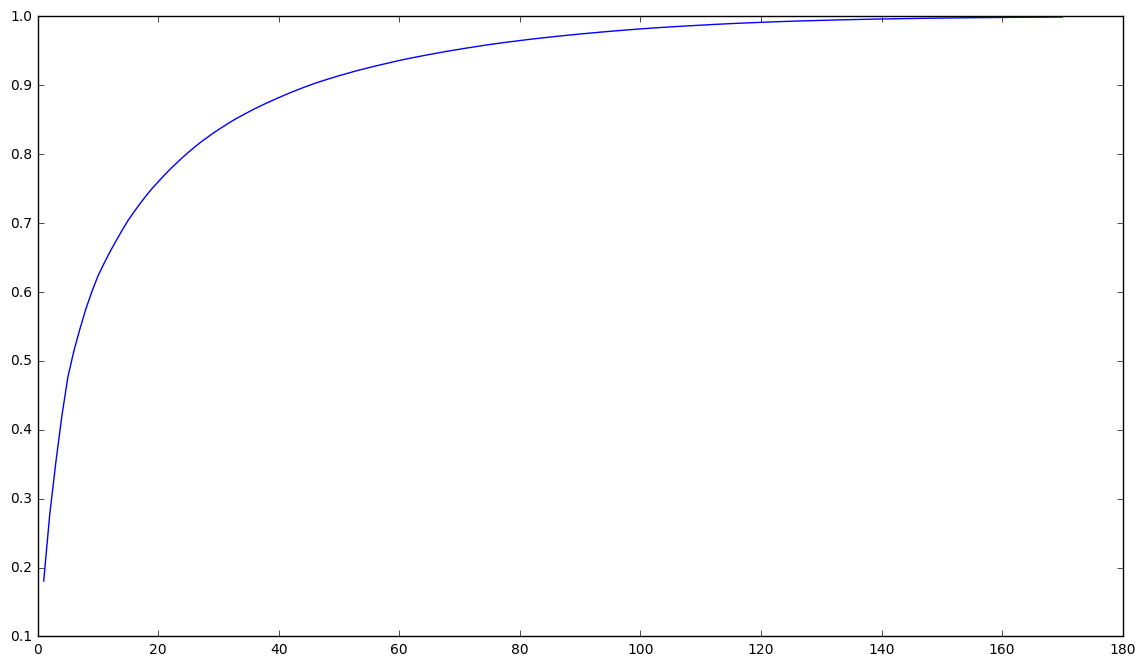

In [38]:
fig = plt.figure(figsize=(14,8))
plt.plot(np.arange(1, len(np.cumsum(pca.explained_variance_ratio_))+1, 1)[:170], 
         np.cumsum(pca.explained_variance_ratio_)[:170])

plt.show

It looks like from the plot above that it would take more than 100 PCs for the cumulative explained variance ratio reache 0.99. We will use another technique to reduce the number of features to go into the classification.

In [39]:
arr_final_df.to_csv('engineered_features_validation_set2.csv', sep=',',  index=False)